### User analysis sur différentes notions du jeux


Lecture des éléments dans le csv et mélange entre tous les joueurs (setup)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Charger les données de tous les joueurs
import os

player_files = [f for f in os.listdir('players') if f.endswith('.csv')]

# Initialiser une liste pour stocker les DataFrames
dfs = []

for file in player_files:
    df = pd.read_csv(os.path.join('players', file))
    dfs.append(df)

# Combiner toutes les données en un seul DataFrame
data = pd.concat(dfs, ignore_index=True)

# Afficher toutes les data
data


,Name,Score,Total Blocks,Just in Time,Normal,Too Early,Up,Down,Left,Right,Start Time,End Time,Duration,Music,Average Reaction Time
0,Aure,265,20,2,16,2,4,4,6,6,2024-11-15 11:31:56,2024-11-15 11:32:13,17.366638,audio (3).mp3,899.350000
1,Aure,4954,302,76,178,48,74,75,68,85,2024-11-15 11:32:21,2024-11-15 11:34:33,132.015783,audio (3).mp3,904.608696
2,Aure,1081,57,17,33,7,15,13,16,13,2024-11-15 11:43:34,2024-11-15 11:44:07,33.454457,funkygroove.mp3,909.058047
3,Aure,2560,148,37,92,19,48,31,36,33,2024-11-15 11:44:15,2024-11-15 11:45:29,74.271826,levels_avicii.mp3,907.935484
4,Aure,69,5,1,4,0,0,1,3,1,2024-11-15 11:45:37,2024-11-15 11:45:49,11.733276,unchained.mp3,908.932331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,victor,1017,125,3,45,77,23,41,31,30,2024-11-15 15:02:38,2024-11-15 15:03:45,67.638977,unchained.mp3,832.426357
66,victor,86,11,1,1,9,5,1,1,4,2024-11-15 15:04:07,2024-11-15 15:04:17,10.134202,levels_avicii.mp3,827.608040
67,victor,35,5,0,1,4,0,1,2,2,2024-11-15 15:04:25,2024-11-15 15:04:32,6.278456,levels_avicii.mp3,827.245658
68,victor,10,2,0,0,2,0,0,1,1,2024-11-15 15:04:40,2024-11-15 15:04:45,5.350628,levels_avicii.mp3,826.580247


Importation des données de la musique et vérification de la matrice de corrélation des données joueurs et données au niveau de la musique

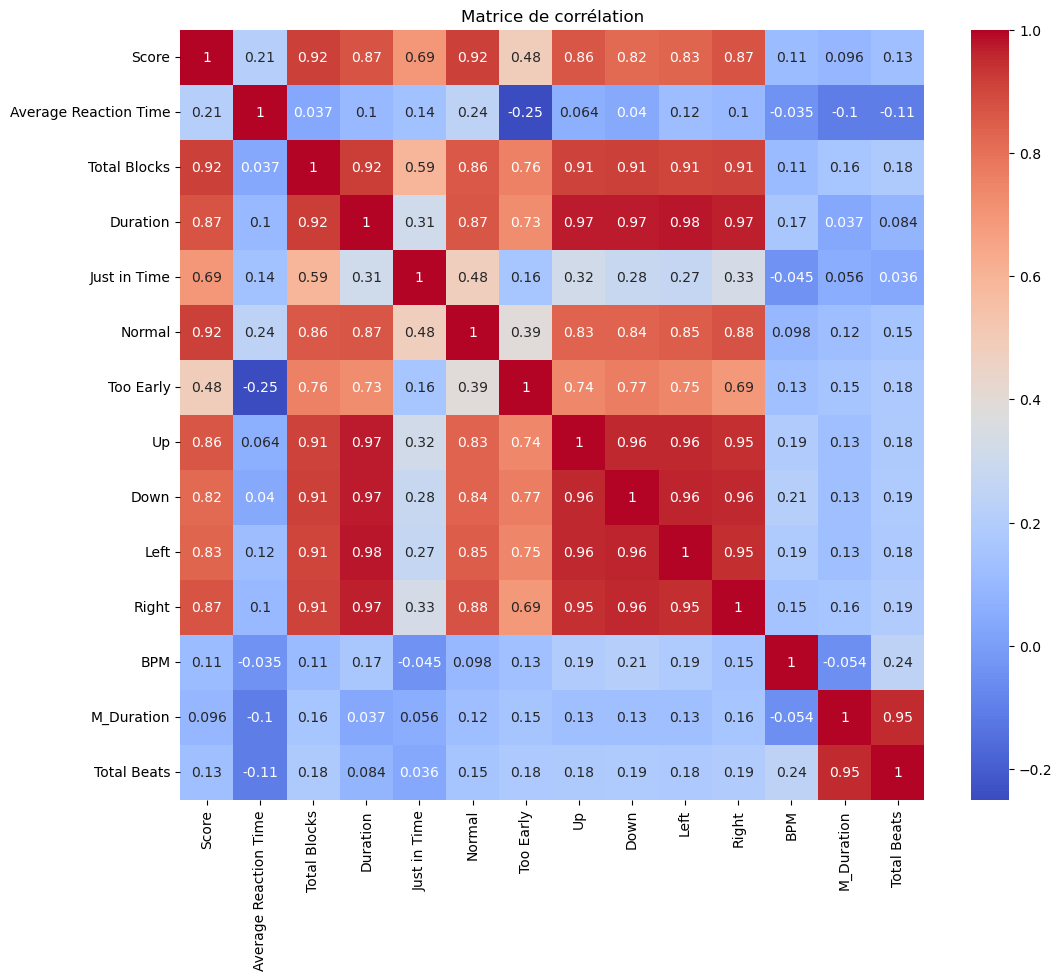

In [2]:
import numpy as np
import librosa

def extract_music_features(music_file):
    y, sr = librosa.load(music_file, sr=None)
    
    # BPM
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    total_beats = len(beat_frames)
    

    
    # Energy
    S, phase = librosa.magphase(librosa.stft(y=y))
    rms = librosa.feature.rms(S=S)

    
    # Loudness
    loudness = rms.mean()
    
    # Duration
    duration = librosa.get_duration(y=y, sr=sr)
  
    features = {
        'Music': os.path.basename(music_file),  
        'Total Beats': total_beats,
        'BPM': tempo,
        'Loudness': loudness,
        'M_Duration': duration,
    }
    
    return features

music_list = ["musics/"+f for f in os.listdir('musics') if f.endswith('.mp3')]


# Créer une liste pour stocker les informations
music_info_list = []


for i in music_list:
    music_info_list.append(extract_music_features(i))

# Créer un DataFrame avec les informations des musiques
music_df = pd.DataFrame(music_info_list)

# Enregistrer en CSV
music_df.to_csv('music_info.csv', index=False)

merged_df = data.merge(music_df, on='Music', how='left')

# Sélection des colonnes numériques
#Vérification de la corrélation entre les éléments
numeric_cols = ['Score', 'Average Reaction Time', 'Total Blocks','Duration' ,'Just in Time', 'Normal', 'Too Early', 'Up', 'Down', 'Left', 'Right', 'BPM','M_Duration','Total Beats' ]

correlation_matrix = merged_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()



## Resultats de la corrélation entre les éléments:

On remarque ainsi qu'il y a une bonne répartition des touches directionels au niveau de l'apparition des zombies 

Le score semble dépendre d'autant la durée de jeux du joueur que du nombre de zombies tués

Le score semble en grande partie être porté lorsque le joueur tue un zombie à une portée normal, moyennement lorsque le zombie est tout prêt et très peu lorsque le zombie est "loin".


Les données au niveau des musiques (Le Beat par Minute, la durée de la musique et le nombre de beat dans chaque musique) ne semble que très peu affecter le score.

## Test d'habilitié en focntion des joueurss 

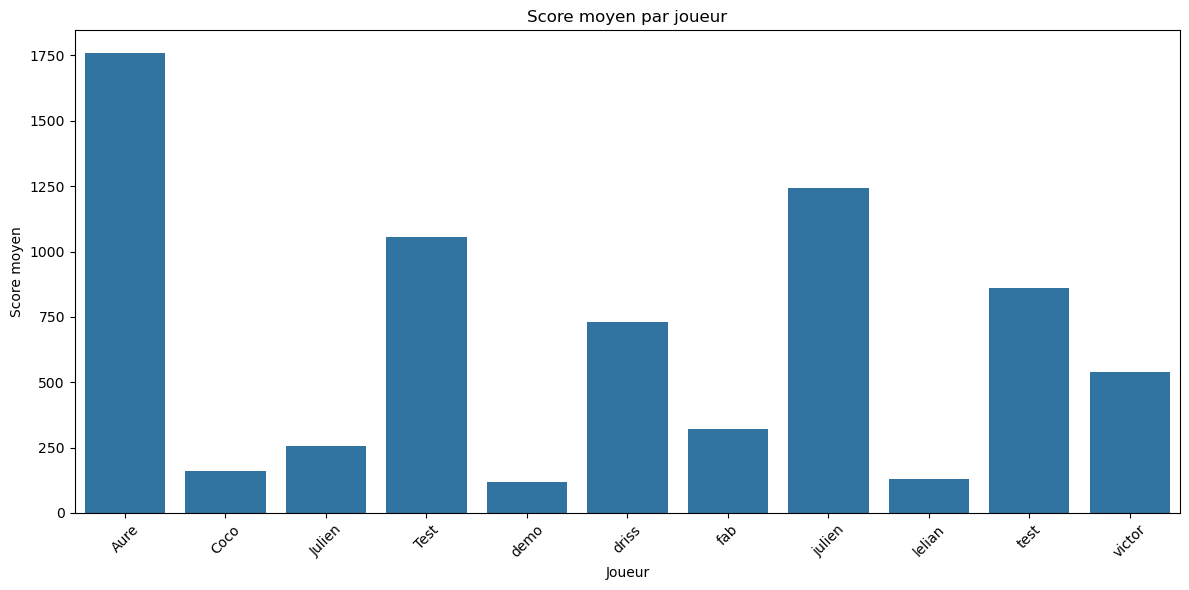

In [3]:
# Calculer le Score moyen par joueur
score_moyen_par_joueur = merged_df.groupby('Name')['Score'].mean().reset_index()

# Tracer un graphique en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=score_moyen_par_joueur, x='Name', y='Score')
plt.title('Score moyen par joueur')
plt.xlabel('Joueur')
plt.ylabel('Score moyen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sans surprise les gens qui ont testé le jeux des miliers de fois (aka le créateur soit: Aure et Test) ont un meilleur score.

## Relation entre le Reaction time et le score

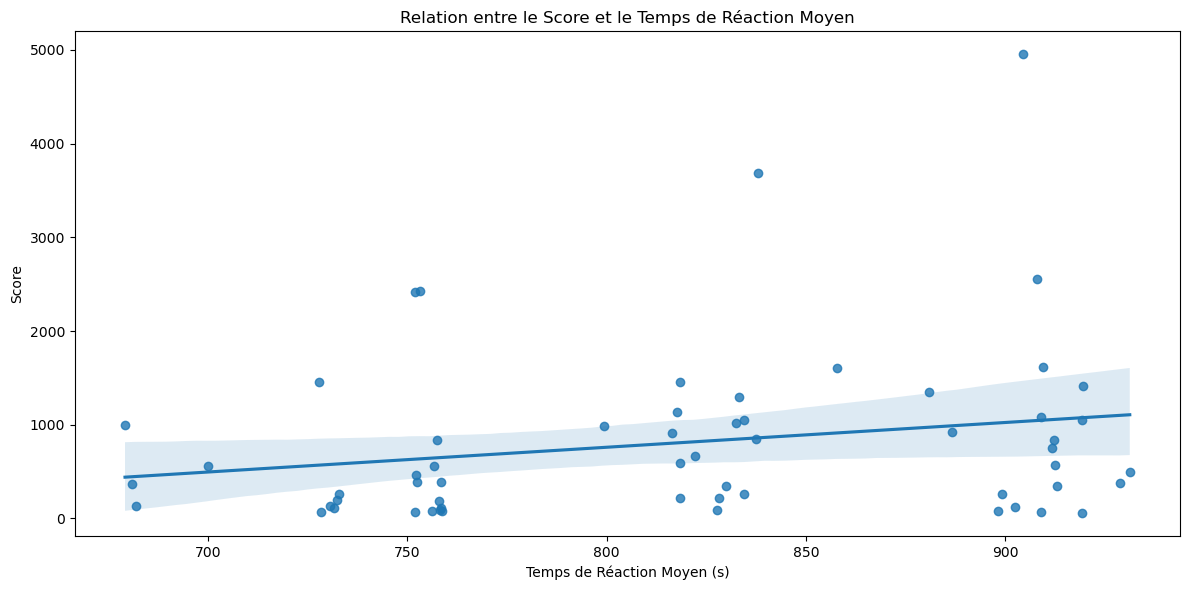

In [4]:
# Définir un seuil pour les scores
seuil = 50
# Filtrer les lignes avec des scores supérieurs ou égaux au seuil
data_filtered = merged_df[merged_df["Score"] >= seuil]

# Tracer un nuage de points avec une ligne de tendance
plt.figure(figsize=(12, 6))
sns.regplot(data=data_filtered, x='Average Reaction Time', y='Score')
plt.title('Relation entre le Score et le Temps de Réaction Moyen')
plt.xlabel('Temps de Réaction Moyen (s)')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


# Réultat de la relation 

Il semble y avoir un lien entre créer le score et le temps de réaction , un Temps de réaction élevé semble signifier un plus haut score

## Analyse de la distribution des zones de touche des zombies 
sachant qu'on les détecte de la manière suivant (les donéne en pixels) : 
if distance < 50:
    self.block_counts['just_in_time'] += 1
elif distance < 125:
    self.block_counts['normal'] += 1
else:
    self.block_counts['too_early'] += 1

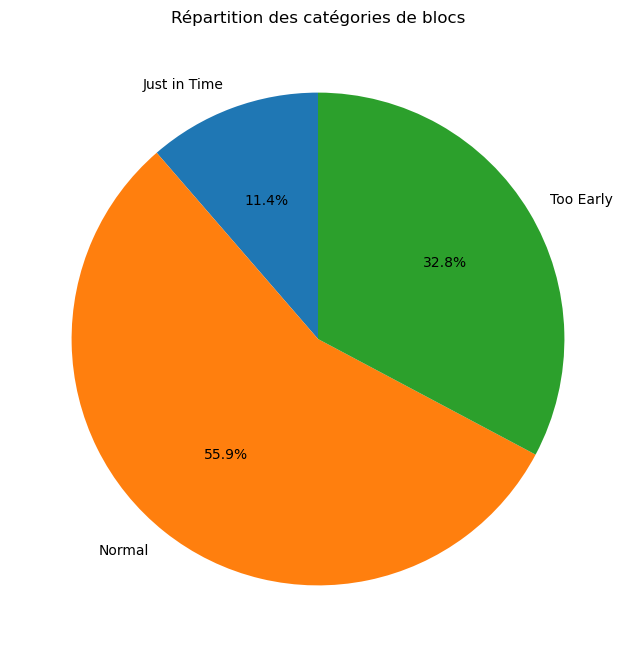

In [5]:
# Somme des catégories de blocs
categories = ['Just in Time', 'Normal', 'Too Early']
blocks_per_category = data[categories].sum()

plt.figure(figsize=(8,8))
blocks_per_category.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Répartition des catégories de blocs')
plt.ylabel('')
plt.show()


On remarque ainsi que les users arrivait la majorité du temps à toucher les zombies dans la zone "normal" de danger.

#### Analyse du nombre de fois qu'un temps de réaction moyens a été calculé

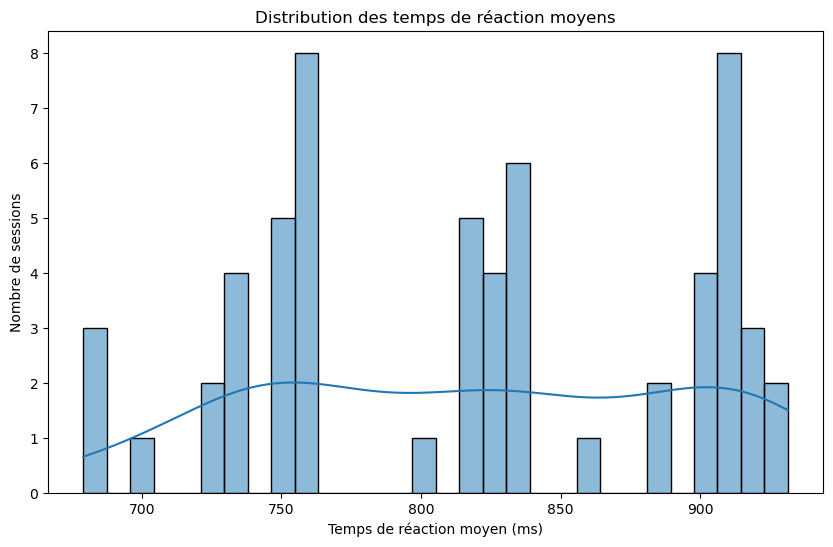

In [6]:
# Définir un seuil pour les scores
seuil = 50
# Filtrer les lignes avec des scores supérieurs ou égaux au seuil
data_filtered = merged_df[merged_df["Score"] >= seuil]

# Arrondir les temps de réaction moyens à 2 décimales
data_filtered["Average Reaction Time"].round()

plt.figure(figsize=(10,6))
sns.histplot(data_filtered['Average Reaction Time'], bins=30, kde=True)
plt.title('Distribution des temps de réaction moyens')
plt.xlabel('Temps de réaction moyen (ms)')
plt.ylabel('Nombre de sessions')
plt.show()
